In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

Read MNIST dataset

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('Datasets/MNIST_data', one_hot=False)
num_train_samples = mnist.train.num_examples
num_valid_samples = mnist.validation.num_examples
num_test_samples = mnist.test.num_examples

print("Number of training samples: %d" % num_train_samples)
print("Number of validation samples: %d" % num_valid_samples)
print("Number of test samples: %d" % num_test_samples)

Extracting Datasets/MNIST_data/train-images-idx3-ubyte.gz
Extracting Datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting Datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting Datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Number of training samples: 55000
Number of validation samples: 5000
Number of test samples: 10000


Define an encoder which encodes images into latent vectors

In [3]:
def encoder(x, layer_units, latent_dim, activation_fn=tf.nn.relu):
    """
    x: the input.
    layer_units: for example, [500, 300] means two layers, one has 500 nodes, another has 300 nodes.
    latent_dim: dimension of latent space.
    """
    input_dim = x.get_shape()[1]
    
    input_tensor = x
    for i in layer_units:
        output_tensor = tf.contrib.layers.fully_connected(input_tensor, i, activation_fn=activation_fn)
        input_tensor = output_tensor
    
    mean = tf.contrib.layers.fully_connected(output_tensor, latent_dim, activation_fn=None)
    #simga is greater than zero, thus add a softplus activation to it.
    sigma = tf.nn.softplus(tf.contrib.layers.fully_connected(output_tensor, latent_dim, activation_fn=None))
    return mean, sigma

Define a decoder which decodes latent vectors to reconstruct images

In [4]:
def decoder(z, layer_units, output_dim, activation_fn=tf.nn.relu):
    """
    z: the latent Gaussian random variables, which are generated by Normal(mean, sigma).
    layer_units: for example, [300, 500].
    ouput_dim: dimension of output, identical to input x.
    """  
    input_dim = z.get_shape()[1]
    
    input_tensor = z
    for i in layer_units:
        output_tensor = tf.contrib.layers.fully_connected(input_tensor, i, activation_fn=activation_fn)
        input_tensor = output_tensor
    
    # output Bernoullis since the original picture is gray scaled.
    x_hat = tf.sigmoid(tf.contrib.layers.fully_connected(output_tensor, output_dim, activation_fn=None))
    return x_hat

Set hyper-parameters

In [5]:
# learning_rate
learning_rate=0.001

batch_size = 100

input_dim = 784
encoder_layer_units = [500, 300]
latent_dim = 20
decoder_layer_units = [300, 500]

output_dim = 784

Loss function of a variational auto-encoder consists of two parts: one is the reconstruction loss; another is the latent loss.

#### 1. Latent Loss (minimizing this loss makes the latent space approximate a distribution)
Assume the latent space is a unit Gaussian distribution, denote by $p(z)\sim{N(0, I_d)}$, the encoder outputs a mean vector $\mu$ and a diagonal cov matrix $\Sigma_q$, reparameterize $q_\phi(z)\sim{N(\mu, \Sigma_q)}$ 

The KL divergence $KL(q||p)$ is given by $$\int{q_\phi(z)[\log(q_\phi(z))-\log(p(z))]dz}$$
Although the original paper(https://arxiv.org/abs/1312.6114) uses a digonal cov matrix which is easy to compute. Here we consider a more general case. The log prob of a Gaussian $q(x)\sim N(\mu_0, \Sigma_0)$ is $$\log[q(x)] = -\frac{1}{2}\big[\log(|\Sigma_0|)+\log(2\pi)+(x-\mu_0)^{T}\Sigma_0^{-1}(x-\mu_0)\big]$$
Given $p(x)\sim N(\mu_1, \Sigma_1)$
$$\log[q(x)]-\log[p(x)]  = -\frac{1}{2}\big[\log(\frac{|\Sigma_0|}{|\Sigma_1|})-(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1)+(x-\mu_0)^{T}\Sigma_0^{-1}(x-\mu_0)\big]$$

The KL divergence $KL(q||p)=E_{x\sim{q(x)}}\big\{\log[q(x)]-\log[p(x)] \big\}$ consists of $E_{x\sim{q(x)}}\big\{(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1)\big\}$ and $E_{x\sim{q(x)}}\big\{(x-\mu_0)^{T}\Sigma_0^{-1}(x-\mu_0)\big\}$

Use the trace trick $E[x^TAx]=E[tr(x^TAx)]=E[tr(Axx^T)]=tr[AE(xx^T)]$

$$\begin{aligned}
\begin{array}
=E_{x\sim{q(x)}}\big\{(x-\mu_1)^{T}\Sigma_1^{-1}(x-\mu_1)\big\} \\
\ \ = tr{\{}\Sigma_1^{-1}E_{x\sim{q(x)}}\big[(x-\mu_1)(x-\mu_1)^T\big]{\}}\\
\ \ = tr{\{}\Sigma_1^{-1}E_{x\sim{q(x)}}\big[(x-\mu_0+\mu_0-\mu_1)(x-\mu_0+\mu_0-\mu_1)^T\big]{\}}\\
\ \ = tr{\{}\Sigma_1^{-1}\Sigma_0{\} +(\mu_0-\mu_1)^T\Sigma_1^{-1}(\mu_0-\mu_1)}\\
\end{array}
 \end{aligned}$$

$$E_{x\sim{q(x)}}\big\{(x-\mu_0)^{T}\Sigma_0^{-1}(x-\mu_0)\big\}=tr{\large\{}\Sigma_0^{-1}E_{x\sim{q(x)}}\big[(x-\mu_0)(x-\mu_0)^T\big]{\large\}}=tr(I_d)=d$$

Hence $KL(q||p)=-\frac{1}{2}\big[\log(\frac{|\Sigma_0|}{|\Sigma_1|})+d-tr{\{}\Sigma_1^{-1}\Sigma_0{\} -(\mu_0-\mu_1)^T\Sigma_1^{-1}(\mu_0-\mu_1)}\big]$

#### 2. Reconstruction Loss
The cross entropy is applied
$$- [X \log(\hat{X}) + (1 - X)\log(1 - \hat{X})]$$

In [6]:
X = tf.placeholder(tf.float32, shape = [None, input_dim])
# Output mean and sigma from encoder
mean, sigma = encoder(X, layer_units=encoder_layer_units, latent_dim=latent_dim)

# The reparameterization trick allows for sampling z
epsilon = tf.random_normal([batch_size, latent_dim], dtype=tf.float32)
z = mean + tf.sqrt(sigma) * epsilon

# Reconstruct input X
X_hat = decoder(z, layer_units=decoder_layer_units, output_dim=output_dim)

# The KL divergence computed above, note that sigma is diagonal, which is represented by a one-dim vector
latent_loss = -0.5 * tf.reduce_sum(tf.log(1e-16 + sigma) - sigma - tf.square(mean), 1)

# The reconstruction loss
decoder_loss = -tf.reduce_sum(X * tf.log(1e-16 + X_hat) + (1 - X) * tf.log(1e-16 + 1 - X_hat), 1)

total_loss = tf.reduce_mean(latent_loss + decoder_loss)

optimizer = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)

In [7]:
training_times = 50001
sess = tf.Session()
sess.run(tf.global_variables_initializer())

average_loss = 0
for i in range(training_times):
    xs, _ = mnist.train.next_batch(batch_size)
    _, loss = sess.run([optimizer,total_loss], feed_dict={X: xs})
    average_loss += loss
    if i % 5000 == 0:
        if i == 0:
            print("Global step %d, average loss: %.2f" % (i, average_loss))
        else:
            print("Global step %d, average loss: %.2f" % (i, average_loss / 5000))
        average_loss = 0

Global step 0, average loss: 555.94
Global step 5000, average loss: 123.66
Global step 10000, average loss: 111.00
Global step 15000, average loss: 108.90
Global step 20000, average loss: 107.80
Global step 25000, average loss: 107.10
Global step 30000, average loss: 106.59
Global step 35000, average loss: 106.19
Global step 40000, average loss: 105.87
Global step 45000, average loss: 105.62
Global step 50000, average loss: 105.39


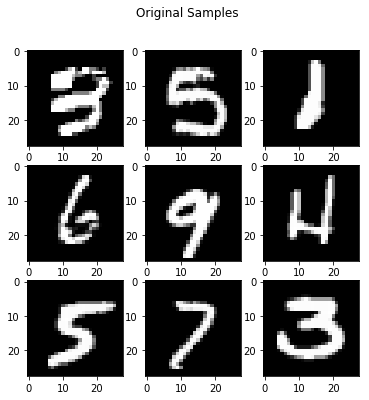

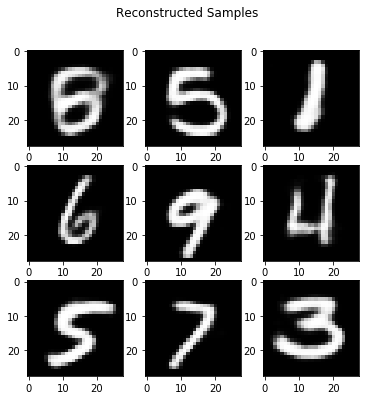

In [8]:
x_sample = mnist.train.next_batch(100)[0]
x_reconstructed = sess.run(X_hat, feed_dict={X:x_sample})
    
ori_samples = x_sample[:9]
plt.figure(figsize=(6, 6))
plt.suptitle("Original Samples")
for i, image in enumerate(ori_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
plt.show()

re_samples = x_reconstructed[:9]
plt.figure(figsize=(6, 6))
plt.suptitle("Reconstructed Samples")
for i, image in enumerate(re_samples):
    plt.subplot(3, 3, i+1)
    plt.imshow(image.reshape(28, 28), cmap="gray")
plt.show()